In [1]:
from autoray import numpy as np
import symmray as sr
import quimb.tensor as qtn
import autoray as ar
from quimb.tensor.tensor_core import  *
from quimb.tensor.tensor_core import bonds, tags_to_oset, rand_uuid
from quimb.tensor.tensor_2d import Rotator2D, pairwise
from vmc_torch.fermion_utils import *

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
Lx = 4
Ly = 4
D = 4
seed = 42
symmetry = 'Z2'

In [3]:
peps, _ = generate_random_fpeps(Lx, Ly, D, seed, symmetry)
norm = peps.make_norm()
norm_peps = peps.multiply(1/np.sqrt(norm.contract()))
norm_peps.make_norm().contract()

1.0000000000000013

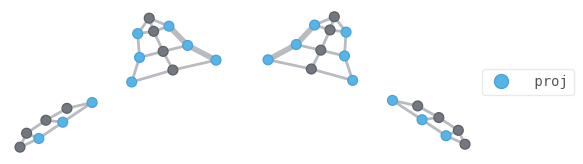

In [53]:
# np.random.seed(42)
random_string = np.random.choice([0,1], size=len(peps.sites))
amp = peps.get_amp(random_string)
# amp.contract()
max_bond = 16
yrange = [0, amp.Ly-1]
if np.sum(random_string) % 2 == 0:
    amp_w_proj = insert_proj_peps(amp, max_bond=max_bond, yrange=yrange)
    amp_w_proj.draw(color='proj')

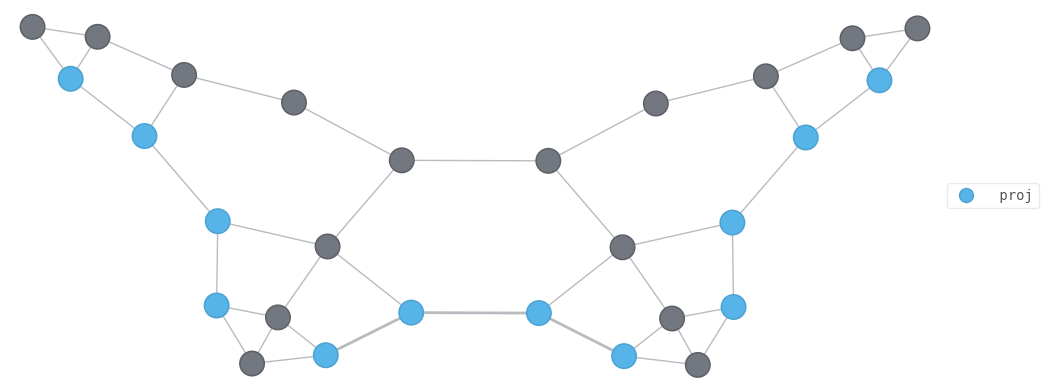

In [31]:
# np.random.seed(0)
random_string = np.random.choice([0,1], size=len(peps.sites))
max_bond = 16
amp = get_amp(peps, random_string)
amp_x = amp.copy()
backend = amp_x.tensors[0].data.backend
amp_x.view_as_(
    qtn.PEPS,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
    x_tag_id="X{}",
    y_tag_id="Y{}",
    Lx=Lx,
    Ly=Ly,
)
for site in amp_x.sites:
    amp_x.contract_tags_(amp_x.site_tag(*site))
    
ltags = [amp_x.site_tag(0,0), amp_x.site_tag(0,1)]
rtags = [amp_x.site_tag(1,0), amp_x.site_tag(1,1)]
tn1 = insert_compressor(amp_x, ltags, rtags, max_bond=max_bond, inplace=False)

ltags = [amp_x.site_tag(1,0), amp_x.site_tag(1,1)]
rtags = [amp_x.site_tag(2,0), amp_x.site_tag(2,1)]
tn2 = insert_compressor(tn1, ltags, rtags, max_bond=max_bond, inplace=False)

ltags = [amp_x.site_tag(2,0), amp_x.site_tag(2,1)]
rtags = [amp_x.site_tag(3,0), amp_x.site_tag(3,1)]
tn3 = insert_compressor(tn2, ltags, rtags, max_bond=max_bond, inplace=False)

ltags = [amp_x.site_tag(0,0), amp_x.site_tag(0,1), amp_x.site_tag(0,2)]
rtags = [amp_x.site_tag(1,0), amp_x.site_tag(1,1), amp_x.site_tag(1,2)]
tn4 = insert_compressor(tn3, ltags, rtags, max_bond=max_bond, inplace=False)

ltags = [amp_x.site_tag(1,0), amp_x.site_tag(1,1), amp_x.site_tag(1,2)]
rtags = [amp_x.site_tag(2,0), amp_x.site_tag(2,1), amp_x.site_tag(2,2)]
tn5 = insert_compressor(tn4, ltags, rtags, max_bond=max_bond, inplace=False)

ltags = [amp_x.site_tag(2,0), amp_x.site_tag(2,1), amp_x.site_tag(2,2)]
rtags = [amp_x.site_tag(3,0), amp_x.site_tag(3,1), amp_x.site_tag(3,2)]
tn6 = insert_compressor(tn5, ltags, rtags, max_bond=max_bond, inplace=False, draw_tn=True)

In [34]:
tn6.contract()

0.24125794997770938

In [7]:
amp2, lrtn = tn4.partition(ltags+rtags, inplace=False)
rtn, ltn = lrtn.partition(ltags, inplace=False)
lts = ltn.contract()
rts = rtn.contract()
bix = bonds(lts, rts)
left_inds = tags_to_oset(lts.inds) - bix
right_inds = tags_to_oset(rts.inds) - bix
print('Left indices:', left_inds)

tdata = lts.data
# tdata.reshape((1,8))
tdata.blocks
# Ql,Rl = lts.split(left_inds=left_inds, get='tensors', method='qr')
# Rr,Qr = rts.split(left_inds=bix, get='tensors', method='lq')

Left indices: oset(['_a770e0AAAAX'])


{(0, 1, 1): array([[[-0.24604743,  0.07062924]]]),
 (0, 0, 0): array([[[0.23598542, 0.01472944]]])}

In [8]:
tdata.reshape((1,8)).blocks

{(0, 0): array([[ 0.23598542,  0.01472944, -0.24604743,  0.07062924]])}

In [9]:
lts

Tensor(shape=(1, 2, 4), inds=('_a770e0AAAAX', 'b(1, 2)-(2, 2)', '_a770e0AAAAJ'), tags=oset(['I1,0', 'I1,1', 'I1,2', 'proj', 'bra', 'X1', 'Y2', 'Y0', 'Y1']))

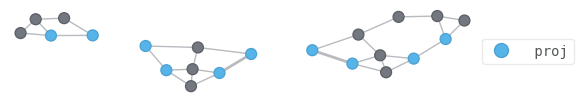

In [10]:
tn5.draw(color='proj')

In [11]:
a = ()
len(a)

0

In [12]:
tn3.tensors[0].data

Z2FermionicArray(shape~(2, 2):[-+], charge=0, num_blocks=2)

In [14]:
test_data = tn3.tensors[0].data.reshape((1,4))
# test_data.blocks
block0 = {(0,0): [[1]]}
test_11 = sr.Z2FermionicArray.from_blocks(blocks=block0, duals=(False, False), symmetry='Z2', charge=0)
test_11._reshape_via_fuse((1,))
sr.abelian_core.reshape_to_fuse_axes(shape=(1,2,4), newshape=(1,8))

((1, 2),)

In [40]:
def reshape_to_fuse_axes(shape, newshape):
    """
    Assuming only fuses need to happen, convert from `reshape` form to
    `fuse` form - a sequence of axes groups.
    """
    i = 0
    d = 1
    groups = []
    group = []
    for dnew in newshape:
        # while d < dnew:
        while d < dnew or (d == dnew == 1 and not group): # BUG: gives incorrect result (empty tuple) when fusing (1,1,) to (1,)
            # accumulate the next axis
            d *= shape[i]
            group.append(i)
            i += 1
        if d != dnew:
            raise ValueError(f"Cannot reshape {shape} to {newshape}")
        if len(group) > 1:
            # only record fused axes
            groups.append(tuple(group))
        # reset
        d = 1
        group = []
    return tuple(groups)

reshape_to_fuse_axes(shape=(1,1,1,2,4), newshape=(1,1,8))

((2, 3, 4),)

In [11]:
test_data = tn3.tensors[0].data.reshape((4,)).copy()
test_data._indices, test_data._blocks
new_ind = sr.BlockIndex(chargemap={0:1}, dual=False)
new_indices = (new_ind, *test_data._indices)
new_blocks = {}
for subsector, block in test_data._blocks.items():
    newsubsector = (0, *subsector)
    newblock = block.reshape((1, *block.shape))
    new_blocks[newsubsector] = newblock
test_data._blocks = new_blocks
test_data._indices = new_indices
test_data._indices, test_data._blocks # reshape each block in the test_data to add a dummy dimension

((BlockIndex(chargemap={0: 1}, dual=False),
  BlockIndex(chargemap={0: 2}, dual=True, subinfo=SubIndexInfo(indices=(BlockIndex(chargemap={0: 1, 1: 1}, dual=True), BlockIndex(chargemap={0: 1, 1: 1}, dual=False)), extents={0: {(0, 0): 1, (1, 1): 1}}))),
 {(0, 0): array([[ 0.0660307 , -0.85929246]])})

In [12]:
test_data.reshape((1,2,2))

Z2FermionicArray(shape~(1, 2, 2):[+-+], charge=0, num_blocks=2)

In [21]:
test_data._indices[0]

BlockIndex(chargemap={0: 1, 1: 1}, dual=True)

In [7]:
# np.random.seed(71)
random_string = np.random.choice([0,1], size=len(peps.sites))
max_bond = 16
amp = get_amp(peps, random_string)
amp_x = amp.copy()
backend = amp_x.tensors[0].data.backend
amp_x.view_as_(
    qtn.PEPS,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
    x_tag_id="X{}",
    y_tag_id="Y{}",
    Lx=Lx,
    Ly=Ly,
)
for site in amp_x.sites:
    amp_x.contract_tags_(amp_x.site_tag(*site))
    
ltags = [amp_x.site_tag(0,0), amp_x.site_tag(0,1)]
rtags = [amp_x.site_tag(1,0), amp_x.site_tag(1,1)]

amp2, lrtn = amp_x.partition(ltags+rtags, inplace=False)
rtn, ltn = lrtn.partition(ltags, inplace=False)
lts = ltn.contract()
rts = rtn.contract()

bix = bonds(lts, rts)

left_inds = tags_to_oset(lts.inds) - bix
right_inds = tags_to_oset(rts.inds) - bix

Ql,Rl = lts.split(left_inds=left_inds, get='tensors', method='qr')
Rr,Qr = rts.split(left_inds=bix, get='tensors', method='lq')

M = (Rl&Rr).contract()

M.drop_tags()
ML, s, MR = M.split(
    left_inds=Ql.bonds(M),
    get='tensors',
    absorb=None,
    method='svd',
    max_bond=max_bond,
    cutoff=0.0,
)
ML_array = ML.data
MR_array = MR.data
# absorb the singular values block by block
for c0, c1 in ML_array.sectors:
    s_sqrt_inv = 1 / ar.do('sqrt', s.data.blocks[c1], like=backend)
    ML_array.blocks[(c0,c1)] *= s_sqrt_inv.reshape((1, -1))
    MR_array.blocks[(c1,c0)] *= s_sqrt_inv.reshape((-1, 1))

def _dual_reverse_array(array, inplace=False):
    """Reverse the dualness of all the indices of an AbelianArray. 
    Safe only when the net charge of the array is 0 and when you know what you're doing."""
    if not inplace:
        array = array.copy()
    new_indices = tuple(ix.conj() for ix in array._indices)
    array._indices = new_indices
    return array
    
ML.modify(data=ML_array.conj())
MR.modify(data=MR_array.conj())

Pl = (Rr|MR).contract()
Pr = (ML|Rl).contract()
new_bix_left = tags_to_oset([rand_uuid(),rand_uuid()])
new_bix_right = tags_to_oset([rand_uuid(),rand_uuid()])
Pl.reindex_(dict(zip(bix, new_bix_left)))
Pr.reindex_(dict(zip(bix, new_bix_right)))
Pl.drop_tags()
Pr.drop_tags()
Pl.add_tag(ltags+['proj'])
Pr.add_tag(rtags+['proj'])
tn_proj = Pl|Pr

ltn.reindex_(dict(zip(bix, new_bix_left)))
rtn.reindex_(dict(zip(bix, new_bix_right)))

tn = amp2|ltn|Pr|Pl|rtn

amp.contract(),tn.contract()

(0.012260566689320707, 0.012260566689320712)

In [10]:
Rr, Qr

(Tensor(shape=(2, 2, 4), inds=('b(0, 0)-(1, 0)', 'b(0, 1)-(1, 1)', '_eb146cAAABM'), tags=oset(['I1,0', 'bra', 'X1', 'Y0', 'I1,1', 'Y1'])),
 Tensor(shape=(4, 2, 2, 2), inds=('_eb146cAAABM', 'b(1, 0)-(2, 0)', 'b(1, 1)-(1, 2)', 'b(1, 1)-(2, 1)'), tags=oset(['I1,0', 'bra', 'X1', 'Y0', 'I1,1', 'Y1'])))

In [29]:
ltn.tensors[0].data

Z2FermionicArray(shape~(2, 2):[++], charge=1, num_blocks=4)

In [12]:
Ql,Rl = lts.split(left_inds=left_inds, get='tensors', method='qr')
(Ql|Rl).contract().data.blocks

sector:(0, 0) array:[[-0.01260845 -1.35424599]] q:[[-1.]] r:[[0.01260845 1.35424599]]
sector:(1, 1) array:[[ 0.58369489 -0.13295199]] q:[[1.]] r:[[ 0.58369489 -0.13295199]]
sector:(0, 1) array:[[-0. -0.]] q:[[1.]] r:[[-0. -0.]]
sector:(1, 0) array:[[-0.  0.]] q:[[1.]] r:[[-0.  0.]]


{(0, 0, 0): array([[[0.]]]),
 (0, 1, 1): array([[[0.]]]),
 (1, 0, 1): array([[[0.]]]),
 (1, 1, 0): array([[[0.]]]),
 (0, 0, 1): array([[[0.]]]),
 (0, 1, 0): array([[[0.]]]),
 (1, 0, 0): array([[[0.]]]),
 (1, 1, 1): array([[[0.]]])}

In [20]:
lts.data.drop_missing_blocks()

In [12]:
Ql.data.blocks, Rl.data.blocks

({(0, 0): array([[-1.]]),
  (1, 1): array([[1.]]),
  (0, 1): array([[1.]]),
  (1, 0): array([[1.]])},
 {(0, 0, 0): array([[[-0.]]]),
  (0, 1, 1): array([[[0.]]]),
  (1, 0, 1): array([[[0.]]]),
  (1, 1, 0): array([[[0.]]])})

In [11]:
lts.inds, left_inds

(('b(0, 0)-(1, 0)', 'b(0, 1)-(0, 2)', 'b(0, 1)-(1, 1)'),
 oset(['b(0, 1)-(0, 2)']))

In [9]:
lts.data.blocks

{(0, 0, 0): array([[[0.01260845]]]),
 (0, 1, 1): array([[[-0.58369489]]]),
 (0, 0, 1): array([[[0.]]]),
 (0, 1, 0): array([[[0.]]]),
 (1, 0, 1): array([[[1.35424599]]]),
 (1, 1, 0): array([[[-0.13295199]]]),
 (1, 0, 0): array([[[0.]]]),
 (1, 1, 1): array([[[0.]]])}

In [19]:
Rr,Qr = rts.split(left_inds=bix, get='tensors', method='lq')
Rr.data.charge, Qr.data.charge

{(0, 0): array([[1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.]]), (1, 1): array([[1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.]]), (1, 0): array([[ 0.18984268,  0.89344511],
       [ 0.94372401, -0.10179132],
       [-0.20602576, -0.01600854],
       [ 0.17577866, -0.43719343]]), (0, 1): array([[ 0.08798059, -0.20716896],
       [-0.5023327 , -0.05256082],
       [ 0.68585701,  0.58198392],
       [-0.51915454,  0.78461016]])} {(0, 0): array([[ 1.99351819, -0.10020381],
       [ 0.        ,  0.18966908]]), (1, 1): array([[ 1.13771894, -0.16705485],
       [ 0.        ,  0.31126338]])}


(0, 1)

In [20]:
rts.data.symmetry.combine()

0

In [21]:
tn.contract(), amp.contract()

In [ ]:
MR.transpose(*MR.inds[::-1]), MR

(Tensor(shape=(4, 2), inds=('_c55d84AAAHp', '_c55d84AAAHq'), tags=oset([])),
 Tensor(shape=(2, 4), inds=('_c55d84AAAHq', '_c55d84AAAHp'), tags=oset([])))

In [ ]:
MR_array.dagger(), MR_array

(Z2FermionicArray(shape~(4, 2):[-+], charge=0, num_blocks=2),
 Z2FermionicArray(shape~(2, 4):[-+], charge=0, num_blocks=2))

In [ ]:
MR_array.conj()

Z2FermionicArray(shape~(2, 4):[+-], charge=0, num_blocks=2)

In [ ]:
Rr.data, MR.data, ML.data, Rl.data

(Z2FermionicArray(shape~(2, 2, 4):[--+], charge=0, num_blocks=4),
 Z2FermionicArray(shape~(2, 4):[-+], charge=0, num_blocks=2),
 Z2FermionicArray(shape~(2, 2):[-+], charge=0, num_blocks=2),
 Z2FermionicArray(shape~(2, 2, 2):[-++], charge=0, num_blocks=4))

In [ ]:
Rr.inds, MR.inds

(('b(0, 0)-(1, 0)', 'b(0, 1)-(1, 1)', '_c55d84AAAEx'),
 ('_c55d84AAAEy', '_c55d84AAAEx'))

In [ ]:
(Rr|MR)

TensorNetwork(tensors=2, indices=4)

In [ ]:
(ML|Rl)

TensorNetwork(tensors=2, indices=4)

In [ ]:
(Rl&Rr).contract().data.blocks

{(0, 0): array([[ 0.08485016, -0.99498812]]),
 (1, 1): array([[-0.76637664, -0.32572714]])}

In [ ]:
(ML | MR).contract().data.blocks

{(0, 0): array([[ 0.08485016, -0.99498812]]),
 (1, 1): array([[-0.76637664, -0.32572714]])}

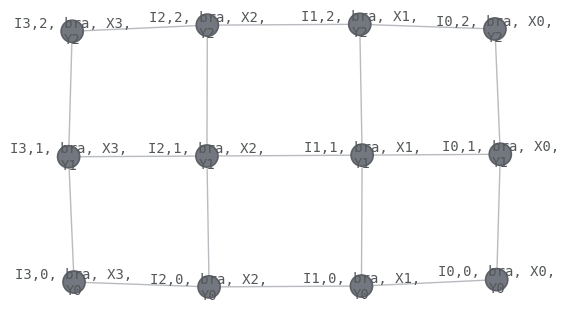

In [ ]:
amp.draw()

In [ ]:
prod(lts.shape[:len(left_inds)])

1

In [ ]:
lts.compute_reduced_factor(side='right', left_inds=left_inds, right_inds=bix)

NotImplementedError: qr only implemented for 2D AbelianArrays, got 1D. Consider fusing first.

In [ ]:
new_shape = (0,4)
non_zero_shape = tuple([i for i in new_shape if i != 0])
non_zero_shape

(4,)

In [ ]:
lts.data.shape

(2, 2)

In [ ]:
ar.do("reshape", lts.data, (0,4))

Z2FermionicArray(shape~(2,):[+], charge=0, num_blocks=1)

In [ ]:
test_array = np.random.random((2,2))
ar.do('reshape', test_array, (4,)) # in func tensor_split, it fails to correctly reshape a matrix into a vector.
# it does sth like reshaping a matrix of shape (2,2) to a vector of shape (0,4), but the correct shape of the vector shoulf be just (4,)

array([0.39187264, 0.31796452, 0.59567522, 0.75176262])

In [ ]:
len((0,4)), lts.data.ndim

(2, 2)

In [ ]:
rts

Tensor(shape=(2, 2), inds=('b(0, 0)-(0, 1)', 'b(1, 0)-(1, 1)'), tags=oset(['I0,1', 'bra', 'X0', 'Y1', 'I1,1', 'X1']))

In [ ]:
amp_x

TensorNetwork(tensors=2, indices=1)

In [ ]:
product_ts2.data.to_dense()

array([0, 1])

In [ ]:
peps.tensors[1].data.blocks

{(0, 0): array([[0.7504512]]), (1, 1): array([[0.94056472]])}

In [ ]:
a = peps.tensors[0].data
t = peps.tensors[0]
data_loc = tuple({'k0,0':0}.get(ix, slice(None)) for ix in t.inds)
data_loc

(slice(None, None, None), 0)

In [ ]:
a.blocks

{(0, 0): array([[0.30471708]]), (1, 1): array([[-1.03998411]])}

In [ ]:
a.to_dense()

array([[ 0.30471708,  0.        ],
       [ 0.        , -1.03998411]])

In [ ]:
t

Tensor(shape=(2, 2), inds=('b(0, 0)-(1, 0)', 'k0,0'), tags=oset(['I0,0', 'X0', 'Y0']))

In [ ]:
peps.isel({'k0,0':0})

TypeError: 'Z2FermionicArray' object is not subscriptable

In [ ]:
params, skeleton =qtn.pack(peps)
qtn.unpack(params, skeleton)

PEPS(tensors=2, indices=3, Lx=2, Ly=1, max_bond=2)

In [ ]:
peps.tensors[0].data

Z2FermionicArray(shape~(2, 2):[++], charge=0, num_blocks=2)

In [ ]:
a, b = map(sr.FermionicOperator, 'ab')
# you can also use strings or pairs like
# adag = 'a+' or ('a', '+')
# a    = 'a-' or ('a', '-')

terms = [
    (+8, (a.dag, a, b.dag, b)),
    (-2, (a.dag, a)),
    (-2, (b.dag, b)),
]

bases = [
    [(), (a.dag,)],
    [(), (b.dag,)],
]

# get just the non-zero elements (with phases)
sr.build_local_fermionic_elements(
    terms, bases
)
# {(0, 1, 0, 1): -2.0, (1, 0, 1, 0): -2.0, (1, 1, 1, 1): -4.0}

{(0, 1, 0, 1): -2.0, (1, 0, 1, 0): -2.0, (1, 1, 1, 1): -4.0}

a+